<a href="https://colab.research.google.com/github/AarnoStormborn/Tensorflow-Developer-Certification/blob/main/05_tensorflow_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow: Fine Tuning

In [1]:
!nvidia-smi

Mon Jan 23 15:25:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.2


## Creating Helper Functions

A Python script containing blocks and functions of code that are repeatedly used

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-23 15:25:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-23 15:25:10 (77.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Data Acquisition

In [5]:
# 10% of 10 Food Classes Data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-23 15:25:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.251.16.128, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   113MB/s    in 1.4s    

2023-01-23 15:25:12 (113 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Walk through the data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [7]:
# Create train and test directories
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

## Load the Images

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32

train_data = image_dataset_from_directory(directory=train_dir,
                                          image_size=IMAGE_SHAPE,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(directory=test_dir,
                                         image_size=IMAGE_SHAPE,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Model 0: Transfer Learning Model using Functional API

In [9]:
# Create base model with tf.keras.Applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base_model
base_model.trainable=False

# Create inputs for model
inputs = tf.keras.layers.Input(shape=(256,256,3), name='input_layer')

# If using ResNet50V2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after inputs: {x.shape}")

# Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after pooling: {x.shape}")

# Output Activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Combine the inputs with the outputs to the model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "model_0")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after inputs: (None, 8, 8, 1280)
Shape after pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20230123-152521
Epoch 1/5
24/24 [==============================] - 20s 272ms/step - loss: 1.8209 - accuracy: 0.4720 - val_loss: 1.2707 - val_accuracy: 0.7418
Epoch 2/5
24/24 [==============================] - 5s 199ms/step - loss: 1.0838 - accuracy: 0.7787 - val_loss: 0.8442 - val_accuracy: 0.8355
Epoch 3/5
24/24 [==============================] - 5s 181ms/step - loss: 0.7864 - accuracy: 0.8467 - val_loss: 0.6920 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 5s 179ms/step - loss: 0.6396 - accuracy: 0.8627 - val_loss: 0.6146 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 5s 200ms/step - loss: 0.5472 - accuracy: 0.8907 - val_loss: 0.5205 - val_accuracy: 0.8783


In [10]:
# Evaluate on full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.5458 - accuracy: 0.8732


[0.5458486080169678, 0.873199999332428]

In [11]:
# Check model layers

for layer_num, layer in enumerate(base_model.layers):
    print(f"{layer_num} {layer.name}")

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [12]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


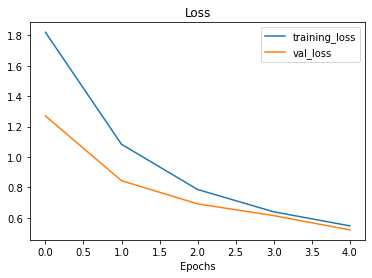

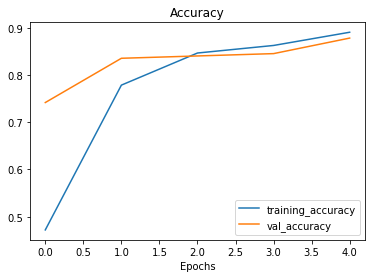

In [14]:
plot_loss_curves(history_0)

## Getting a Feature Vector from Trained Model

In [15]:
# Understanding Global Average Pooling
input_shape = (1,4,4,3)

# Random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)

# Pass tensor through Global Average Pooling layer
gap_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"gap tensor: {gap_tensor.shape}\n{gap_tensor}")

gap tensor: (1, 3)
[[-0.09368646 -0.45840448 -0.2885598 ]]


In [16]:
# Replicate gap operation
print(tf.reduce_mean(input_tensor, axis=[1,2]))

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


In [17]:
# Global Max Pooling layer
gmp_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"gmp tensor: {gmp_tensor.shape}\n{gmp_tensor}")

gmp tensor: (1, 3)
[[0.9058464 1.1603122 1.6994323]]


In [18]:
mp_tensor = tf.keras.layers.MaxPooling2D(3,3)(input_tensor)
print(f"gmp tensor: {mp_tensor.shape}\n{mp_tensor}")

gmp tensor: (1, 1, 1, 3)
[[[[0.9058464 0.539707  1.6994323]]]]


## Series of Experiments to Perform

1. `model_1` - Feature Extraction with 1 % data with augmentation
2. `model_2` - Feature Extraction with 10% data with augmentation
3. `model_3` - Fine Tuning with 10% data with augmentation
4. `model_4` - Fine Tuning with 100% data with augmentation

**Note:** Evaluation data will remain same for all experiments to ensure consistency 

### Experiment 1 - model_1

In [19]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-01-23 15:26:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   143MB/s    in 0.9s    

2023-01-23 15:26:12 (143 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [21]:
# Create train and test directories
train_dir_1 = "10_food_classes_1_percent/train"
test_dir_1 = "10_food_classes_1_percent/test"

#### Load Images

In [22]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_1 = image_dataset_from_directory(train_dir_1,
                                       image_size=IMAGE_SHAPE,
                                       label_mode='categorical',
                                       batch_size=BATCH_SIZE)

test_1 = image_dataset_from_directory(test_dir_1,
                                      image_size=IMAGE_SHAPE,
                                      label_mode='categorical',
                                      batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Data Augmentation as a Sequential layer

In [23]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Create a Sequential Data Augmentation layer
augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) Only for ResNet50V2
], name='data_augmentation')

#### Model 1

In [24]:
# Setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze base_model
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=(256,256,3), name='input_layer')

# Pass input to Data Augmentation layer
x = augmentation(inputs)

# Pass augmented input to base model
x = base_model(x)

# Global Average Pooling 2D
x = layers.GlobalAveragePooling2D()(x)

# Create Output layer
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Put the model together
model_1 = Model(inputs, outputs)

# Compile the model
model_1.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_1,
                        epochs=5,
                        steps_per_epoch=len(train_1),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning","model_1")])

Saving TensorBoard log files to: transfer_learning/model_1/20230123-152616
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4132 - accuracy: 0.1143 - val_loss: 2.2049 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1427 - accuracy: 0.2714 - val_loss: 2.0763 - val_accuracy: 0.2697
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9816 - accuracy: 0.3571 - val_loss: 1.9754 - val_accuracy: 0.3569
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8437 - accuracy: 0.4571 - val_loss: 1.8791 - val_accuracy: 0.4030
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6763 - accuracy: 0.5286 - val_loss: 1.7982 - val_accuracy: 0.4622


In [25]:
# Evaluate the data
model_1.evaluate(test_data)

79/79 [==============================] - 7s 87ms/step - loss: 1.7917 - accuracy: 0.4612


[1.7917418479919434, 0.4611999988555908]

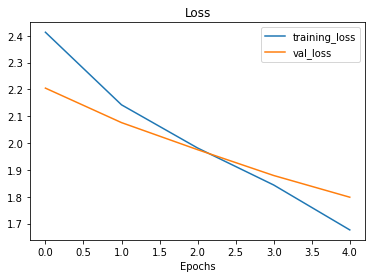

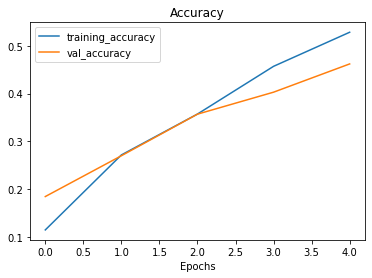

In [26]:
plot_loss_curves(history_1)

### Experiment 2 - model_2

#### Model 2

In [56]:
# Setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Input layer
inputs = layers.Input(shape=(256,256,3), name='input_layer')

# Augmentation
x = augmentation(inputs)

# Base model
x = base_model(x, training=False)

# Pooling
x = layers.GlobalAveragePooling2D()(x)

# Output layer
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Model
model_2 = Model(inputs, outputs)

# Compile
model_2.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

#### Model Checkpoint Callback

In [57]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_weights/checkpoint.ckpt"

# Create ModelCheckpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [58]:
# Fit Model 2
initial_epochs = 5

history_2 = model_2.fit(train_data,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning","model_2"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_2/20230123-181150
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9861 - accuracy: 0.3640
Epoch 1: saving model to ten_percent_model_weights/checkpoint.ckpt
24/24 [==============================] - 19s 534ms/step - loss: 1.9861 - accuracy: 0.3640 - val_loss: 1.4258 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2952 - accuracy: 0.6960
Epoch 2: saving model to ten_percent_model_weights/checkpoint.ckpt
24/24 [==============================] - 12s 467ms/step - loss: 1.2952 - accuracy: 0.6960 - val_loss: 0.9745 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9910 - accuracy: 0.7680
Epoch 3: saving model to ten_percent_model_weights/checkpoint.ckpt
24/24 [==============================] - 12s 463ms/step - loss: 0.9910 - accuracy: 0.7680 - val_loss: 0.7860 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] 

In [59]:
result = model_2.evaluate(test_data)
result

79/79 [==============================] - 7s 87ms/step - loss: 0.6218 - accuracy: 0.8420


[0.6217866539955139, 0.8420000076293945]

In [60]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.5458 - accuracy: 0.8732


[0.5458486080169678, 0.873199999332428]

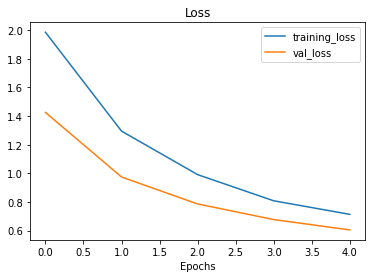

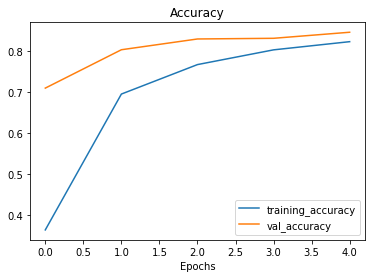

In [61]:
plot_loss_curves(history_2)

#### Loading Checkpointed Model Weights

In [62]:
# Load 
model_2.load_weights(checkpoint_path)

In [63]:
# Evaluate model 2 with loaded weights
loaded_result = model_2.evaluate(test_data)

79/79 [==============================] - 7s 87ms/step - loss: 0.6218 - accuracy: 0.8420


In [64]:
# Check if numbers are very close if not equal (due to precision)
import numpy as np

np.isclose(np.array(result), np.array(loaded_result))

array([ True,  True])

### Experiment 3 - model_3 (Fine Tuning)

In [65]:
# Check layers of model_2
model_2.layers

In [66]:
# Check if layers are trainable
for layer in model_2.layers:
    print(layer.trainable, layer.name)

True input_layer
True data_augmentation
False efficientnetb0
True global_average_pooling2d_3
True output_layer


In [67]:
# Check base model layers
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 tf.math.truediv_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [68]:
# For fine tuning, unfreeze all layers
base_model.trainable = True

# Freeze all layers except last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model
model_2.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(learning_rate=0.0001), # lower lr for fine tuning
                metrics=["accuracy"])

In [69]:
# Check base model layers again
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 tf.math.truediv_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

#### Model 3 (Model 2 but Fine Tuned)

In [70]:
# Fine Tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

history_2_ft = model_2.fit(train_data,
                           epochs=fine_tune_epochs,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=int(0.25 * len(test_data)),
                           initial_epoch=history_2.epoch[-1], # Start training from previous layer
                           callbacks=[create_tensorboard_callback("transfer_learning", "model_2_ft")])

Saving TensorBoard log files to: transfer_learning/model_2_ft/20230123-181339
Epoch 5/10
24/24 [==============================] - 18s 476ms/step - loss: 0.6113 - accuracy: 0.8413 - val_loss: 0.4926 - val_accuracy: 0.8470
Epoch 6/10
24/24 [==============================] - 11s 434ms/step - loss: 0.4896 - accuracy: 0.8600 - val_loss: 0.4221 - val_accuracy: 0.8684
Epoch 7/10
24/24 [==============================] - 10s 411ms/step - loss: 0.4074 - accuracy: 0.8707 - val_loss: 0.4279 - val_accuracy: 0.8668
Epoch 8/10
24/24 [==============================] - 11s 445ms/step - loss: 0.3609 - accuracy: 0.8947 - val_loss: 0.4236 - val_accuracy: 0.8701
Epoch 9/10
24/24 [==============================] - 11s 441ms/step - loss: 0.3349 - accuracy: 0.9133 - val_loss: 0.4081 - val_accuracy: 0.8651
Epoch 10/10
24/24 [==============================] - 9s 372ms/step - loss: 0.3160 - accuracy: 0.9053 - val_loss: 0.4113 - val_accuracy: 0.8684


In [71]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.4026 - accuracy: 0.8692


[0.402609258890152, 0.8691999912261963]

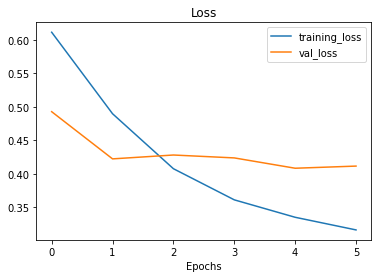

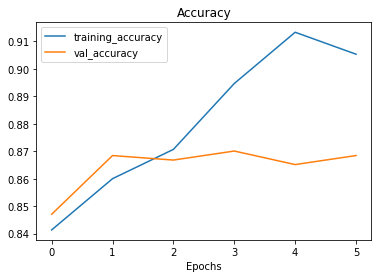

In [72]:
plot_loss_curves(history_2_ft)

In [73]:
# Function to compare histories
import matplotlib.pyplot as plt

def compare_histories(original_history, new_history, initial_epochs=5):
    
    # Original history
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original with new
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make Plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")

    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")

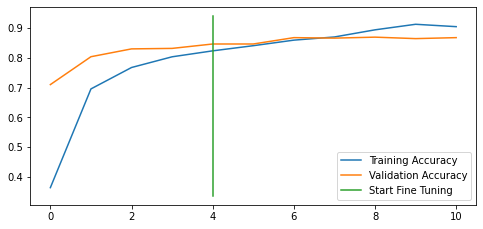

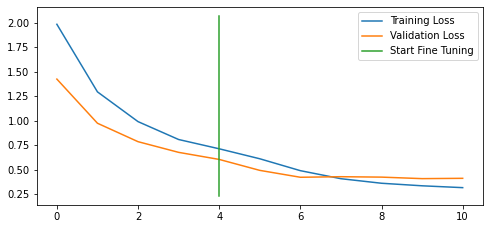

In [74]:
compare_histories(history_2, history_2_ft)

### Experiment 4 - model_4

In [75]:
# Get 100% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2023-01-23 18:15:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 142.251.167.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  89.8MB/s    in 4.1s    

2023-01-23 18:15:13 (119 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [76]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [77]:
# Setup training directory
train_dir_all = "10_food_classes_all_data/train"

In [78]:
train_data_all = image_dataset_from_directory(train_dir_all,
                                              label_mode="categorical",
                                              image_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.


In [79]:
# Reloading model_2 to checkpoint before fine tuning
model_2.load_weights(checkpoint_path)

In [80]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.6218 - accuracy: 0.8420


[0.6217865943908691, 0.8420000076293945]

In [81]:
result

[0.6217866539955139, 0.8420000076293945]

In [82]:
# Check if base_model layers are still trainable
for i, layer in enumerate(base_model.layers):
    if layer.trainable:
        print(i, layer.name)

228 block7a_se_squeeze
229 block7a_se_reshape
230 block7a_se_reduce
231 block7a_se_expand
232 block7a_se_excite
233 block7a_project_conv
234 block7a_project_bn
235 top_conv
236 top_bn
237 top_activation


In [83]:
# Recompile model_2
model_2.compile(loss=CategoricalCrossentropy(),
                            optimizer=Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

fine_tune_epochs = initial_epochs + 5

history_4 = model_2.fit(train_data_all,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_all),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback("transfer_learning","model_4")])

Saving TensorBoard log files to: transfer_learning/model_4/20230123-182150
Epoch 5/10
235/235 [==============================] - 83s 326ms/step - loss: 0.6228 - accuracy: 0.8041 - val_loss: 0.3428 - val_accuracy: 0.8914
Epoch 6/10
235/235 [==============================] - 69s 293ms/step - loss: 0.4965 - accuracy: 0.8403 - val_loss: 0.2857 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - 65s 275ms/step - loss: 0.4269 - accuracy: 0.8636 - val_loss: 0.2922 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 59s 251ms/step - loss: 0.3928 - accuracy: 0.8752 - val_loss: 0.2836 - val_accuracy: 0.9079
Epoch 9/10
235/235 [==============================] - 56s 236ms/step - loss: 0.3589 - accuracy: 0.8887 - val_loss: 0.2939 - val_accuracy: 0.9046
Epoch 10/10
235/235 [==============================] - 57s 240ms/step - loss: 0.3308 - accuracy: 0.8924 - val_loss: 0.2292 - val_accuracy: 0.9211


In [84]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 87ms/step - loss: 0.2447 - accuracy: 0.9156


[0.24474868178367615, 0.9156000018119812]

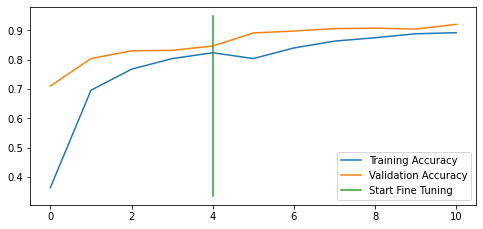

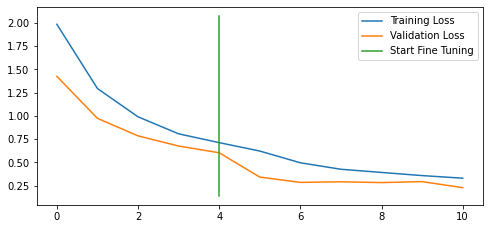

In [85]:
compare_histories(history_2, history_4)

## Compare Model results with TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning with Fine Tuning" \
--description "Series of experiments with Fine Tuning on EfficientNetB0" \
--one_shot

In [88]:
# https://tensorboard.dev/experiment/MVNFA0wgRXWQHmaoJmtpdg/